In [1]:
import pandas as pd
from gensim.test.utils import get_tmpfile
from gensim.models.doc2vec import Doc2Vec
import pickle
import numpy as np
import matplotlib.pyplot as plt

c:\users\costanza\appdata\local\programs\python\python37-32\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [38]:
from gensim.parsing.preprocessing import preprocess_string
import re
import string
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import strip_multiple_whitespaces
from gensim.parsing.preprocessing import stem_text
from gensim.parsing.preprocessing import strip_numeric
def remove_ip(s):
    # Replace all ip adresses with '<ip>' tag
    ip_regexp = r"\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b"
    return re.sub(ip_regexp, '<ip>', s)
def remove_email(s):
    # Replace all email adresses with '<email>' tag
    email_regexp = r"([a-zA-Z0-9_\-\.]+)@([a-zA-Z0-9_\-\.]+)\.([a-zA-Z]{2,5})"
    return re.sub(email_regexp, '<email>', s)
def remove_mailto(s):
    # Replace all "<mailto:<email>>" with <email>. Email adresses should be replaced by remove_email first.
    return s.replace("<mailto:<email>>", "<email>")
def remove_url(s):
    # Replace all url's with '<url>' tag
    url_regexp = r"((http|ftp|https):\/\/)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)"
    s = re.sub(url_regexp, '<url>', s)
    # Sometimes url's are inside <> so we need to replace <<url>> with <url>
    return s.replace("<<url>>", "<url>")
def remove_punc(s, exceptions):
    # Remove all punctuation from string with exceptions in list exceptions
    remove = string.punctuation
    for exception in exceptions:
        remove = remove.replace(exception, "")
    # Create the pattern
    pattern = r"[{}]".format(remove)

    return re.sub(pattern, "", s)
def remove_custom_stopwords(s, stopwords):
    for stopword in stopwords:
        s = s.replace(stopword, "")
    return s
def lower_case(s):
    return s.lower()
def preprocess_sentence_fn(s):
    # Preprocess a single sentence to a list of tokens
    punc_exceptions = ['<', '>']
    custom_stopwords = ['dear', 'sincerely', 'thanks', 'yours', 'regards']
    filters = [lower_case,
               remove_ip,
               remove_email,
               remove_mailto,
               remove_url,
               lambda x: remove_punc(x, punc_exceptions),
               remove_stopwords,
               lambda x: remove_custom_stopwords(x, custom_stopwords),
               strip_multiple_whitespaces,
               stem_text,
               strip_numeric]
    out = preprocess_string(s, filters=filters)
    return out
def preprocess_docs_fn(docs):
    # Apply preprocess_sentence_fn to a list of sentances (docs) to get a list of lists
    return [preprocess_sentence_fn(s) for s in docs]

In [39]:
# Read in the data
ticket_dat = pd.read_csv('../../data/ticket_dat.csv')
faq_dat = pd.read_csv('../../data/faq_dat.csv')
# Replace the NaNs
ticket_dat.fillna('', inplace=True)
faq_dat.fillna('', inplace=True)
# Make sentences into
faq_ques = list(faq_dat.question)
n_faq_ques = len(faq_ques)
# FAQ answer is the answer and its title concatenated
faq_ans = list(faq_dat.answer_title + " " + faq_dat.answer)
n_faq_ans = len(faq_ans)
ticket_ques = list(ticket_dat.question)
n_ticket_ques = len(ticket_ques)
ticket_ans = list(ticket_dat.answer)
n_ticket_ans = len(ticket_ans)
# Model assumption: same embedding for all
all_docs = faq_ques + faq_ans + ticket_ques + ticket_ans
# create a dictionary storing the cut points for the four datasets so we can re-split them after.    
# use like all_docs[id_dict['faq_ques']] to get all faq questions.
id_dict = {
    'faq_ques': range(0, n_faq_ques),
    'faq_ans': range(n_faq_ques, n_faq_ques + n_faq_ans),
    'ticket_ques': range(n_faq_ques + n_faq_ans, n_faq_ques + n_faq_ans + n_ticket_ques),
    'ticket_ans': range(n_faq_ques + n_faq_ans + n_ticket_ques, n_faq_ques + n_faq_ans + n_ticket_ques + n_ticket_ans)
}
# Need to save this list and id dictionary as a pickle so we can decode IDs when we test things
with open("../embedding/models/doc_data/all_docs.txt", "wb") as fp:
    pickle.dump(all_docs, fp)
with open("../embedding/models/doc_data/id_dict.txt", "wb") as fp:
    pickle.dump(id_dict, fp)
all_docs_prepro = preprocess_docs_fn(all_docs)
model_path = '../embedding/models/doc2vec.model'
model = Doc2Vec.load(model_path)
#model dimensions [10785, 128]
print('Loading Document Data...')
# Unpickle the document data
with open("../embedding/models/doc_data/all_docs.txt", "rb") as fp:
    all_docs = pickle.load(fp)
with open("../embedding/models/doc_data/id_dict.txt", "rb") as fp:
    id_dict = pickle.load(fp)
ticket_ans_ids = np.array(id_dict['ticket_ans'])
all_faq_ans = id_dict['faq_ans']
print('The FAQ answers can be found in the following {}'.format(all_faq_ans))
print('The tickets have the following ids {}'.format(ticket_ans_ids))

In [177]:
def sim_to_faq(doc_id):
    # Computes similarity to all faqs for a given doc_id
    dists = model.docvecs.distances(doc_id, other_docs=())
    return np.array(dists[all_faq_ans])

In [280]:
sim_to_faq_vec = np.vectorize(sim_to_faq, otypes=[object])
print('Computing Similarities...')
ticket_faq_dists = np.stack(sim_to_faq_vec(ticket_ans_ids)) #array w/ similarity btw each ticket_ans and each faq ans
ticket_faq_map = np.argmin(ticket_faq_dists, axis=1)

Computing Similarities...


In [294]:
print(np.amin(ticket_faq_map))
print(np.amax(ticket_faq_map))
print(np.mean(ticket_faq_map))
print(np.std(ticket_faq_map))

0
388
195.03776978417267
126.07803708479139
5


Counter({367: 175, 54: 149, 323: 117, 349: 103, 39: 82, 33: 72, 321: 70, 9: 69, 81: 66, 336: 66, 181: 65, 196: 58, 195: 56, 12: 53, 303: 51, 353: 50, 258: 49, 6: 49, 45: 45, 296: 44, 158: 43, 256: 43, 119: 42, 82: 42, 22: 41, 163: 41, 371: 40, 377: 38, 260: 37, 16: 36, 387: 35, 7: 35, 36: 33, 265: 32, 261: 30, 102: 30, 335: 29, 360: 29, 21: 29, 310: 29, 42: 28, 165: 28, 193: 28, 362: 28, 107: 28, 31: 27, 94: 27, 19: 26, 313: 26, 356: 25, 172: 25, 20: 23, 364: 23, 250: 23, 11: 23, 51: 23, 388: 22, 66: 22, 209: 21, 106: 21, 213: 21, 307: 21, 167: 20, 103: 20, 67: 20, 280: 20, 151: 20, 354: 20, 4: 20, 212: 19, 322: 19, 259: 19, 124: 19, 24: 19, 383: 19, 194: 19, 197: 18, 270: 18, 5: 18, 83: 18, 376: 18, 168: 18, 29: 18, 231: 18, 60: 17, 219: 17, 338: 17, 324: 17, 171: 16, 326: 16, 214: 16, 50: 16, 169: 16, 276: 16, 273: 15, 104: 15, 188: 15, 13: 15, 184: 15, 55: 15, 98: 15, 386: 15, 284: 14, 43: 14, 58: 14, 208: 14, 319: 14, 75: 14, 131: 14, 223: 14, 277: 14, 346: 14, 350: 14, 281: 13, 28

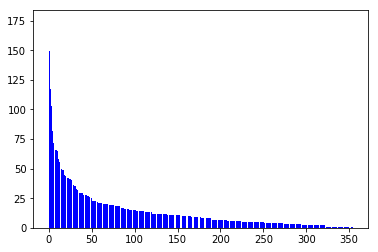

In [281]:
all_l = Counter(ticket_faq_map)
all_k=all_l.most_common()
print(all_k)

all_y = [0]*len(all_k)
for i in range(0,len(all_k)):
    all_y[i] = all_k[i][1]
    
#all_b = [1, 51, 101, 151, 201, 251, 301]
#names = np.array(x)[b]
plt.bar(range(0,len(all_y)), all_y, color='blue')
#plt.xticks([0, 50, 100, 150, 200, 250, 300, 350], names)
plt.show()

In [293]:
ticket_faq_dists.shape

(5004, 389)

In [179]:
print(len(ticket_faq_dists)) #number of rows
print(len(ticket_faq_dists[0])) #number of columns

5004
389


In [278]:
big_dist = [ticket_faq_dists.min(axis=1) > 0.8]
ticket_faq_map[big_dist] = -1 # Set all thresholded distances to have label -1

c:\users\costanza\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


In [279]:
print(big_dist)
print(ticket_faq_map)
print('number of tickets without an FAQ:{}' .format(list(ticket_faq_map).count(-1)))
print(len(list(ticket_faq_map)))

[array([False, False, False, ..., False, False, False])]
[284   9 171 ...   6 196  67]
number of tickets without an FAQ:38
5004


In [143]:
dic = np.empty((390,2), dtype=int)
for i in range(0,390):
    dic[i,0] = i
    dic[i,1] = 0
for i in range(0,len(list(ticket_faq_map))):
    dic[list(ticket_faq_map)[i],1] += 1
dic[389,1] = list(ticket_faq_map).count(-1)

In [136]:
print(dic[list(ticket_faq_map)[0],0])
print(dic[list(ticket_faq_map)[0],1])
print(list(ticket_faq_map).count(284))

284
8
8


In [213]:
from collections import Counter
l = Counter(ticket_faq_map)
print(l)
print()
k=l.most_common()
print(k)

Counter({-1: 794, 367: 168, 54: 149, 323: 115, 349: 102, 39: 82, 33: 72, 9: 69, 81: 66, 336: 66, 181: 65, 196: 56, 195: 54, 12: 53, 303: 51, 258: 49, 6: 49, 321: 47, 353: 45, 296: 44, 256: 43, 119: 42, 22: 41, 158: 40, 163: 40, 82: 40, 45: 38, 7: 35, 371: 35, 387: 34, 265: 32, 36: 30, 16: 30, 102: 30, 335: 29, 261: 29, 21: 29, 260: 28, 165: 28, 107: 28, 42: 27, 94: 27, 19: 26, 313: 26, 310: 26, 356: 25, 172: 25, 20: 23, 250: 23, 11: 23, 31: 22, 66: 22, 209: 21, 106: 21, 360: 21, 67: 20, 151: 20, 354: 20, 4: 20, 259: 19, 24: 19, 197: 18, 83: 18, 124: 18, 29: 18, 231: 18, 270: 17, 377: 17, 338: 17, 383: 17, 103: 16, 364: 16, 194: 16, 326: 15, 214: 15, 388: 15, 376: 15, 104: 15, 168: 15, 55: 15, 171: 14, 362: 14, 277: 14, 386: 14, 51: 14, 213: 14, 5: 13, 319: 13, 28: 13, 114: 13, 184: 13, 337: 13, 188: 12, 75: 12, 255: 12, 169: 12, 131: 12, 162: 12, 223: 12, 14: 12, 48: 12, 251: 12, 215: 12, 173: 12, 98: 12, 274: 11, 325: 11, 1: 11, 281: 11, 267: 11, 201: 11, 126: 11, 292: 11, 43: 10, 290

In [240]:
x = [0]*len(k)
y = [0]*len(k)
for i in range(0,len(k)):
    x[i] = k[i][0]
    y[i] = k[i][1]

In [210]:
faq_dat.loc[x[1:21]]

,Unnamed: 0,faq_id,lang,answer,answer_title,question
367,367,8501,de,Thank you for forwarding the suspicious messag...,,Got phishing email?
54,54,9026,en,This post will be very short and is mainly to ...,What is Breadcrumbs?,What is Breadcrumbs in SharePoint?
323,323,9231,de,The maximum file size which can be uploaded or...,Maximum file size polybox,"Is there a maximum file size in the polybox, w..."
349,349,9305,de,Dear ISG Mr. Meng Li (mli) has a contaminated ...,,Verseuchter Rechner / Mail an ISG
39,39,9006,en,On this website you will find the contact pers...,Website Contacts Departments,How do I find my IT manager in the department?
33,33,8968,en,Please download first all software local to y...,,How can I install software from IDES?
9,9,8532,en,Please download first all software local to y...,Software installation from IDES,How can I install software from IDES?
81,81,9066,en,When you break permissions inheritance between...,Would you like to delete unique permissions an...,Would you like to delete unique permissions an...
336,336,9279,de,1. Click on the top link on Site Action 2. Cli...,,Change the logo on the SharePoint page
181,181,8521,de,Please find attached the information to the ma...,Answer mass mail,Bulk mail


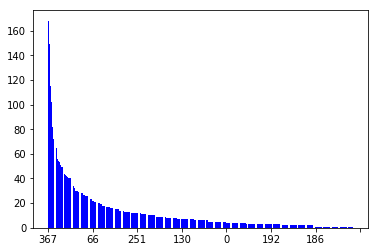

In [266]:
b = [1, 51, 101, 151, 201, 251, 301]
names = np.array(x)[b]
plt.bar(range(1,len(y)), y[1:len(y)], color='blue')
plt.xticks([0, 50, 100, 150, 200, 250, 300, 350], names)
plt.show()

In [224]:
print(np.mean(y))
print(np.std(y))
print(np.amin(y))
print(np.amax(y))

14.631578947368421
46.31318440308018
1
794
